# LogBook

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/yggdrasil-decision-forests/blob/main/documentation/public/docs/tutorial/log_book.ipynb)

The **Log Book** is a utility for tracking and analyzing ML experiments.

**Note:** While useful for ML (including YDF), it's not specific to YDF or ML and suits various experiments.

With the Log Book, you can:

- **Test** if an experiment (identified by a JSON-serializable Python dictionary key) already exists.

- **Log** an experiment with its key and a result (also a JSON-serializable Python dictionary). Records are immediately available to all connected instances.

- **Export** experiment to a Pandas DataFrame for analysis and plotting.

**Note:** YDF hyper-parameters and evaluations are dictionaries, simplifying logging.

The Log Book supports defining default values for parameters. This is useful when adding new parameters to experiments, allowing consistent comparison with older experiments lacking that explicit parameter.

The Log Book is powered by a SQLite database that allows multiple programs or users to access the same logbook simultaneously. For instance, a training script can write to it while you monitor results in a Colab.

This notebook first shows the supported operations using toy data. Then, it shows how to apply these operations to test and evaluate various ML parameters, such as hyper-parameters and feature processing settings. Note that for classical hyper-parameter tuning (i.e., finding the learner hyper-parameters that maximize the quality of a model), the hyperparameter tuner tool is more focused and efficient. 


In [ ]:
!pip install ydf tqdm -q -U

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import ydf

## Toy data

Let's create a toy log book.

**Note:** If you use Google Colab, local files are removed automatically after some time of inactivity. Make sure to save the log book file.

In [11]:
# Create / load an existing logbook
logbook = ydf.util.LogBook(directory="my_logbook_1")

Found 0 experiments


Check for the existing of an expriment.

In [12]:
# Define an experiment key. An experiment key is simply an arbitrary dictionary
experiment_1 = {"param1": 1, "param2": "hello"}
# Check if the experiment already exists in the logbook
logbook.exist(experiment_1)

False

As expected, the experiment does not exist.

In [13]:
# Create the experiment
logbook.add(
    key={"param1": 1, "param2": "hello"},
    result={"result1": 1, "result2": [1, 2, 3]},
)

In [14]:
# Check that the experiment now exists.
logbook.exist({"param1": 1, "param2": "hello"})

True

In [15]:
# List all the experiments.
logbook.to_dataframe()

,id,timestamp,param1,param2,result1,result2
0,1,2025-05-16 14:07:34,1,hello,1,"[1, 2, 3]"


**Note:** Experiment keys are not unique. If a user adds multiple experiments with the same key, they will appear at different rows with a different "id" and "timestamps".

Let's add more experiments (with different keys) to show how queries and plotting works:

In [16]:
# Add more experiments
logbook.add(key={"param1": 3, "param2": "hello"}, result={"result1": 5})
# Create the experiment
logbook.add(
    key={"param1": 2, "param2": "world", "param3": 3.1415},
    result={"result1": 8},
)

# List all the experiments again.
logbook.to_dataframe()

,id,timestamp,param1,param2,result1,result2,param3
0,1,2025-05-16 14:07:34,1,hello,1,"[1, 2, 3]",NaN
1,2,2025-05-16 14:07:34,3,hello,5,NaN,NaN
2,3,2025-05-16 14:07:34,2,world,8,NaN,3.1415


**Note:** Different experiments can have different key and result items (for example `param3` only exist in the last experiment).

Let's only grab the experiments with `param2="hello"`.

In [17]:
logbook.to_dataframe({"param2": "hello"})

,id,timestamp,param1,param2,result1,result2
0,1,2025-05-16 14:07:34,1,hello,1,"[1, 2, 3]"
1,2,2025-05-16 14:07:34,3,hello,5,NaN


Now, let's plot `result1` according to `param1`.

<Axes: xlabel='param1'>

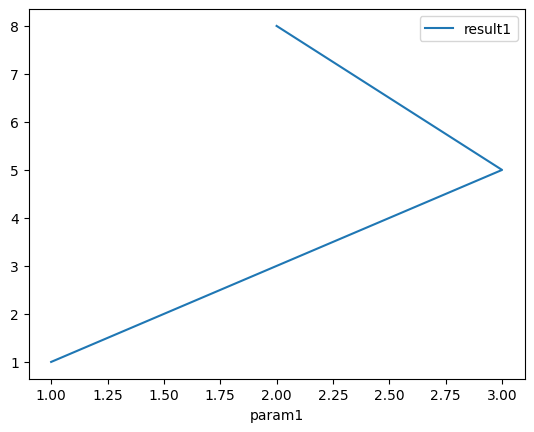

In [18]:
logbook.to_dataframe().plot(x="param1", y="result1")

## Real experiment

In this section, we use the log book to a real experiment. Here, we study the impact of reducing the number of training examples on the quality of our model. We also want to understand how this is impacted by different learner parameters. For instance, maybe some parameters make the model more resistant to reducing the number of training examples.

**Note:** This kind of analysis is useful in practice. It helps understand if having **more** training examples would help.

Let's create out log book:

In [19]:
logbook = ydf.util.LogBook(directory="my_logbook_2")

Found 0 experiments


Let's load the "Abalone" dataset. The objective is to predict the `Rings` column using all the other columns as features.

In [20]:
dataset_path = "https://raw.githubusercontent.com/google/yggdrasil-decision-forests/main/yggdrasil_decision_forests/test_data/dataset"
dataset = pd.read_csv(f"{dataset_path}/abalone.csv")

print("Number of examples:", len(dataset))

dataset.head()

Number of examples: 4177


,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [21]:
from sklearn.model_selection import train_test_split

train_ds, test_ds = train_test_split(dataset, test_size=0.2, random_state=42)

Let's create an iterator that generate the parameters of our experiments. Using a python generator (i.e., using `yield`) makes it easy to manage complex experiments as you can "compose" them.

In [22]:
def gen_experiment_parameters():
  # How much of the dataset is used, between 0 and 1.
  for num_examples_ratio in np.linspace(0.05, 1, num=5):
    for max_depth in [3, 4, 5]:
      for shrinkage in [0.05, 0.1, 0.15]:
        # You can organize the paramers hierarchically. For example,
        # the learner paramers and the dataset parameres are split
        # in two sub-dictionary.
        #
        # Note: YDF hyper-parameres are list here:
        # https://ydf.readthedocs.io/en/latest/hyperparameters/
        yield {
            "dataset": {"num_examples_ratio": num_examples_ratio},
            "learner": {"max_depth": max_depth, "shrinkage": shrinkage},
        }


num_experiments = len(list(gen_experiment_parameters()))
print(f"We have {num_experiments} experiment(s)")

print("The first 5 experiments to run:")
for idx, key in enumerate(gen_experiment_parameters()):
  if idx == 5:
    break
  print(key)

We have 45 experiment(s)
The first 5 experiments to run:
{'dataset': {'num_examples_ratio': np.float64(0.05)}, 'learner': {'max_depth': 3, 'shrinkage': 0.05}}
{'dataset': {'num_examples_ratio': np.float64(0.05)}, 'learner': {'max_depth': 3, 'shrinkage': 0.1}}
{'dataset': {'num_examples_ratio': np.float64(0.05)}, 'learner': {'max_depth': 3, 'shrinkage': 0.15}}
{'dataset': {'num_examples_ratio': np.float64(0.05)}, 'learner': {'max_depth': 4, 'shrinkage': 0.05}}
{'dataset': {'num_examples_ratio': np.float64(0.05)}, 'learner': {'max_depth': 4, 'shrinkage': 0.1}}


We need a function to run the experiment.

In [23]:
def run_experiment(parameters):
  reduced_train_dataset = train_ds.sample(
      frac=parameters["dataset"]["num_examples_ratio"]
  )
  model = ydf.GradientBoostedTreesLearner(
      label="Rings", task=ydf.Task.REGRESSION
  ).train(reduced_train_dataset, verbose=0)
  evaluation = model.evaluate(test_ds)
  return {"rmse": evaluation.rmse}


# Let's run it on a simple parameter:
run_experiment({
    "dataset": {"num_examples_ratio": 0.05},
    "learner": {"max_depth": 3, "shrinkage": 0.05},
})

{'rmse': 2.4293587827508376}

Let's join both methods together.

**Note:** If your experiment takes a long time to run, or if you have many experiments to run, it make sense to run them in parallel on different computers. Remember, a log book can be used at the same time by multiple programs.

In [24]:
num_experiments = len(list(gen_experiment_parameters()))
for experiment_key in tqdm(gen_experiment_parameters(), total=num_experiments):

  if logbook.exist(experiment_key):
    # We skip experiments that have already be run.
    # This is great to augment or add new paramers later.
    continue

  experiment_result = run_experiment(experiment_key)
  logbook.add(experiment_key, experiment_result)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:04<00:00,  9.74it/s]


After a little while, we can look the experiment results.

In [25]:
logbook.to_dataframe().head()

,id,timestamp,dataset,learner,rmse
0,1,2025-05-16 14:07:36,{'num_examples_ratio': 0.05},"{'max_depth': 3, 'shrinkage': 0.05}",2.493999
1,2,2025-05-16 14:07:36,{'num_examples_ratio': 0.05},"{'max_depth': 3, 'shrinkage': 0.1}",2.607531
2,3,2025-05-16 14:07:36,{'num_examples_ratio': 0.05},"{'max_depth': 3, 'shrinkage': 0.15}",2.615266
3,4,2025-05-16 14:07:36,{'num_examples_ratio': 0.05},"{'max_depth': 4, 'shrinkage': 0.05}",2.501007
4,5,2025-05-16 14:07:36,{'num_examples_ratio': 0.05},"{'max_depth': 4, 'shrinkage': 0.1}",2.641298


Let's plot the model quality (we want the RMSE to be as small as possible) vs our parameters.

Text(0, 0.5, 'rmse')

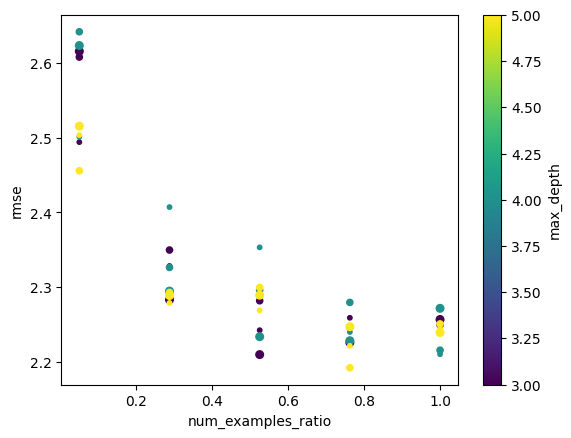

In [26]:
results = logbook.to_dataframe()

_rmse = results["rmse"]
_num_examples_ratio = results["dataset"].map(lambda x: x["num_examples_ratio"])
_max_depth = results["learner"].map(lambda x: x["max_depth"])
_shrinkage = results["learner"].map(lambda x: x["shrinkage"])

plot = plt.scatter(
    _num_examples_ratio, _rmse, c=_max_depth, s=_shrinkage * 200, cmap="viridis"
)
plt.colorbar(plot).set_label("max_depth")
plt.xlabel("num_examples_ratio")
plt.ylabel("rmse")

In this analysis, we can see how much our model RMSE worsened. It also seems that having a high max_depth parameter gives both good and bad results. This can mean that increasing max_depth makes the training more noisy. This is expected, since a deep trees are more prone to overfitting on the training data.

This is just a starting point. A natural continuation would be to see if other parameters could help. Also, our evaluation might also be noisy. Maybe we should run each experiment multiple times (with different dataset splits) to quantify the variability.